<a href="https://colab.research.google.com/github/rivero-frank/ASL-Classifier/blob/main/Transfer_Learning_Model_ASL_Classifier_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code will run in this Colab, but the Colab doesn't have enough RAM, so it'll crash when you start training the model.

In [ ]:
# Install libraries (if you already have them, you don't need to run this code)
%pip install tensorflow

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [ ]:
!unzip "/content/American_Sign_Language_Letters.v1-v1.multiclass.zip" -d "/content"

# Data Processing

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/valid"

def load_data(data_dir, img_size=(224, 224)):
    X, y = [], []
    for file in os.listdir(data_dir):
        if file.endswith(".jpg"):
            img_path = os.path.join(data_dir, file)
            with Image.open(img_path) as img:
                img = img.resize(img_size)
                img_array = preprocess_input(np.array(img, dtype=np.float32))
                label = file[0]
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y)

# Load data
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

In [ ]:
# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_valid = label_binarizer.transform(y_valid)
y_test = label_binarizer.transform(y_test)

In [ ]:
target_names = label_binarizer.classes_

In [ ]:
#Data aug
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)
datagen.fit(X_train)

# Transfer Learning Model

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune the model

model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(target_names), activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
class_weights = {i: len(y_train) / (len(target_names) * (y_train[:, i].sum())) for i in range(len(target_names))}

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weights,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30


/Users/hossainmd/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.0675 - loss: 9.5572 - val_accuracy: 0.1111 - val_loss: 9.5162 - learning_rate: 1.0000e-04
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2116 - loss: 8.2307 - val_accuracy: 0.2014 - val_loss: 8.6524 - learning_rate: 1.0000e-04
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3408 - loss: 7.5671 - val_accuracy: 0.2431 - val_loss: 8.3003 - learning_rate: 1.0000e-04
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.4592 - loss: 7.0094 - val_accuracy: 0.3472 - val_loss: 7.9263 - learning_rate: 1.0000e-04
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5622 - loss: 6.4037 - val_accuracy: 0.4236 - val_loss: 7.9171 - learning_rate: 1.0000e-04
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7131 - loss: 5.8776 - val_accuracy: 0.3681 - val_loss: 8.8423 - learning_rate: 1.0000e-04
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7231 - loss: 5.6130 - 

EVAL

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Model accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
Model accuracy: 0.72


In [ ]:
unique_classes_in_test = np.unique(y_test_classes)
all_classes = np.arange(len(target_names))

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, labels=unique_classes_in_test, target_names=target_names[unique_classes_in_test]))

# Print confusion matrix
print(confusion_matrix(y_test_classes, y_pred_classes, labels=unique_classes_in_test))

              precision    recall  f1-score   support

           A       0.33      1.00      0.50         1
           B       1.00      1.00      1.00         3
           C       1.00      0.75      0.86         4
           D       0.50      1.00      0.67         1
           F       1.00      0.50      0.67         2
           G       0.71      1.00      0.83         5
           H       1.00      0.33      0.50         3
           I       1.00      0.50      0.67         2
           J       1.00      1.00      1.00         4
           K       1.00      0.50      0.67         4
           M       0.00      0.00      0.00         3
           N       0.17      0.33      0.22         3
           O       1.00      1.00      1.00         3
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         2
           R       0.50      0.50      0.50         2
           S       0.60      1.00      0.75         3
           T       1.00    

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


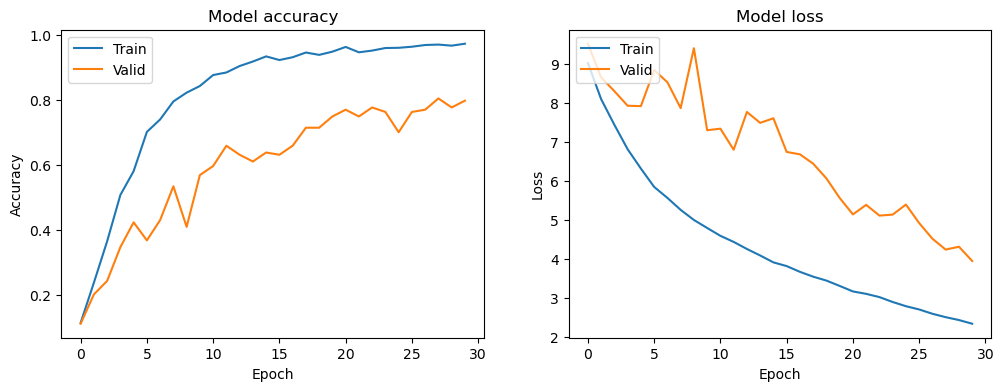

In [ ]:
# Step 9: Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

# LIVE FEED CAPTURE

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/asl_model.keras.zip" -d "/content"

Archive:  /content/asl_model.keras.zip
  inflating: /content/asl_model.keras  
  inflating: /content/__MACOSX/._asl_model.keras  


In [ ]:
model.load_weights('asl_model.keras')

In [ ]:
!pip install tensorflow opencv-python pillow numpy

# Live Feed Capture

In [ ]:
def prepare_image(image, target_size=(224, 224)):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = np.array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


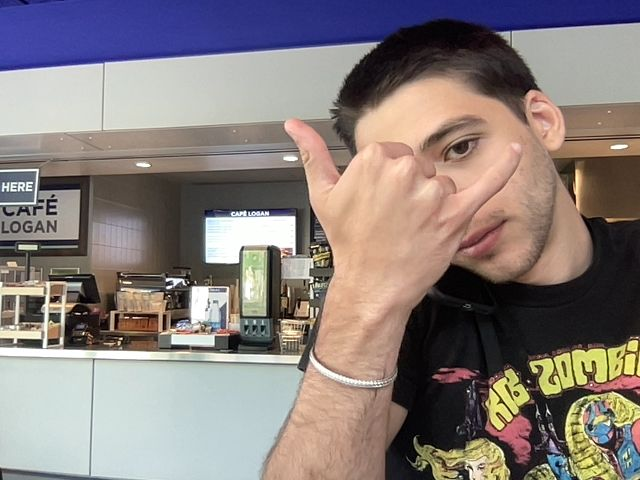

In [ ]:
from IPython.display import Image as img
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(img(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#Loads and prepares the example image
example_image_path = '/content/photo.jpg'  # Update with the image path
image = Image.open(example_image_path)
prepared_image = prepare_image(image)

In [ ]:
preds = model.predict(prepared_image)
pred_class = target_names[np.argmax(preds)]

print(f'Predicted class: {pred_class}')

1/1 [==============================] - 0s 61ms/step
Predicted class: Q


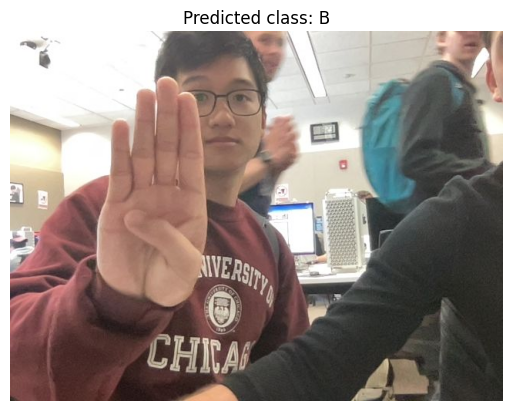

In [ ]:
plt.imshow(image)
plt.title(f'Predicted class: {pred_class}')
plt.axis('off')
plt.show()